In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import altair as alt
import plotnine as pn
import warnings
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_grid, theme, element_text, scale_x_discrete

warnings.simplefilter('ignore')
pn.options.figure_size = (10, 15)
plt.style.use('ggplot')

# TOC Thematic Report - February 2019 (part 4: relative change scatterplots)

This is a rough/quick notebook to generate plots for Heleen's presentation at the WGE meeting in March 2019. The broad aim is to recreate Fig. 2 from Øyvind G's [2014 trends paper](https://link.springer.com/article/10.1007/s11270-014-1880-6).

**Update - 21/05/2019:** I have now modified the code in this notebook to include data from all 555 sites in the "full" ICPW dataset.

**Update 2 - 03/06/2019:** Øyvind's Fig. 2 does not include ANC or alkalinity. His method is to divide each value in the series by the first value, thereby obtaining numbers relative to the first year. However this does not work for ANC or alkalinity, which can be negative (see e-mail sent to Øyvind at 02.06.2019 at 23.33 for an explanation). This can be corrected by shifting the data prior to scaling. The most usual approach is "standardisation", which involves subtracting the mean and dividing by the standard deviation. For the application here, I will instead **substract the first value in the series and divide by the standard deviation**, which gives results more comparable with Øyvind's original plots, because each series should then start from a common point at zero (instead of 1 on Øyvind's version).

## 1. Stations

In [2]:
# Read station data
stn_path = r'../../../all_icpw_sites_may_2019.xlsx'
stn_df = pd.read_excel(stn_path, sheet_name='all_icpw_stns')
stn_df.dropna(subset=['region'], inplace=True)
print(len(stn_df))
stn_df.head()

555


,station_id,station_code,station_name,latitude,longitude,altitude,continent,country,region,group
0,38115,Tr18_CA_DO1,Blue Chalk Lake,45.1999,-78.9432,344.0,North America,Canada,Ont,Trends
1,38116,Tr18_CA_DO2,Chub Lake,45.2138,-78.9836,343.0,North America,Canada,Ont,Trends
2,38117,Tr18_CA_DO3,Crosson Lake,45.0840,-79.0360,371.0,North America,Canada,Ont,Trends
3,38118,Tr18_CA_DO4,Dickie Lake,45.1510,-79.0876,379.0,North America,Canada,Ont,Trends
4,38119,Tr18_CA_DO5,Harp Lake,45.3798,-79.1335,327.0,North America,Canada,Ont,Trends


## 2. Water chemsitry

In [3]:
# Load saved data
wc_csv = r'../../../Thematic_Trends_Report_2019/working_chem.csv'
wc_df = pd.read_csv(wc_csv, encoding='utf-8')
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date'])

# Annual medians by site
wc_df['year'] = wc_df['sample_date'].dt.year
agg_df = wc_df.groupby(['station_id', 'year']).median().reset_index()
agg_df.head()

,station_id,year,depth1,depth2,TOC,EH,ESO4X,ENO3,ECaX_EMgX,ANC,ALK-E
0,23472,1990,0.0,0.0,NaN,3.630781,44.499714,23.571429,63.201619,10.939799,NaN
1,23472,1993,0.0,0.0,NaN,3.630781,47.620048,35.000000,46.966952,-15.749821,NaN
2,23472,1995,0.0,0.0,NaN,3.352035,43.698143,34.285714,68.968857,1.265627,4.0
3,23472,1997,0.0,0.0,NaN,2.041738,37.982524,25.000000,52.235143,3.383879,4.0
4,23472,2000,0.0,0.0,NaN,1.584893,33.889353,36.161583,56.657019,4.324865,4.0


In [4]:
# Loop over sites
df_list = []
for idx, row in stn_df.iterrows():
    # Get station metadata
    stn_id = row['station_id']
    region = row['region']

    # Read series
    df = agg_df.query('station_id == @stn_id').copy()

    # Delete unwanted cols and tidy
    del df['station_id'], df['depth1'], df['depth2']
    df.set_index('year', inplace=True)
    df.sort_index(inplace=True)
    
    # Get first value in series
    for col in df.columns:
        # Values equal to exactly zero must be wrong
        # Convert to NaN
        df[col][df[col]==0] = np.nan
        vals = df[col].dropna().values
        
        # If at least one valid value in series, get the first
        if len(vals) > 0:
            first = vals[0]
        else:
            first = np.nan
            
        # Apply scaling
        df[col] = (df[col] - first) / df[col].std()

    # Build results df
    df['region'] = region
    df['station_id'] = stn_id
    df.reset_index(inplace=True)
    df_list.append(df)
    
# Combine and tidy
df = pd.concat(df_list, axis=0)
df['year'] = df['year'].astype(int)
df.reset_index(inplace=True, drop=True)
df = df.melt(id_vars=['year', 'region', 'station_id'])

# Ignore Baltic countries and Moldova (not in Øyvind's paper and 
# some strange data)
df = df.query('region != "Moldova"')

df.head()

,year,region,station_id,variable,value
0,1990,Ont,38115,TOC,0.000000
1,1991,Ont,38115,TOC,0.178090
2,1992,Ont,38115,TOC,-0.095895
3,1993,Ont,38115,TOC,0.945247
4,1994,Ont,38115,TOC,-0.246586


## 3. Explore data
### 3.1. All data

The code below uses Altair to create an interactive plot. Hovering the mouse over any point will display information, including the station code. This makes it much easier to identify problem data series.

In [6]:
## Altair plot
#alt.data_transformers.enable('default', max_rows=None)
#c = alt.Chart(df).mark_point().encode(
#      x='year:O',
#      y=alt.Y('value:Q', axis=alt.Axis(title='')),
#      color=alt.Color('station_id:O', legend=None),
#      tooltip='station_id:O',
#).properties(
#      width=60,
#      height=150,
#).facet(
#      column=alt.Column('region', sort=['NoNord', 'SoNord', 'Baltic', 'UK-IE-NL', 'WCE', 'ECE', 'Alps', 
#                                        'AtlCan', 'QuMaVt', 'AdsCsk', 'Apps', 'BRM', 'Ont']),
#      row=alt.Column('variable', sort=['ESO4X', 'ENO3', 'ECaX_EMgX', 'TOC', 'EH', 'ANC'])
#).resolve_scale(
#      y='independent'
#).interactive()
#c

In [7]:
# Convert 'region' and 'variable' to custom categorical data types
reg_type = pd.api.types.CategoricalDtype(categories=['NoNord', 'SoNord', 'Baltic', 'UK-IE-NL', 'WCE', 'ECE', 'Alps', 
                                                     'AtlCan', 'QuMaVt', 'AdsCsk', 'Apps', 'BRM', 'Ont'],
                                         ordered=True)
df['region'] = df['region'].astype(reg_type)

var_type = pd.api.types.CategoricalDtype(categories=['ESO4X', 'ENO3', 'ECaX_EMgX', 'TOC', 'EH', 'ANC', 'ALK-E'],
                                         ordered=True)
df['variable'] = df['variable'].astype(var_type)

df.head()

,year,region,station_id,variable,value
0,1990,Ont,38115,TOC,0.000000
1,1991,Ont,38115,TOC,0.178090
2,1992,Ont,38115,TOC,-0.095895
3,1993,Ont,38115,TOC,0.945247
4,1994,Ont,38115,TOC,-0.246586


The code below uses [plotnine](https://plotnine.readthedocs.io/en/latest/index.html) to generate a facet-grid of the data with a similar layout to the version in Øyvind's paper. Note, however, that I'm using **lowess smoothing** here rather than cubic splines, and the approach to scaling is also different (see notebook introduction above).

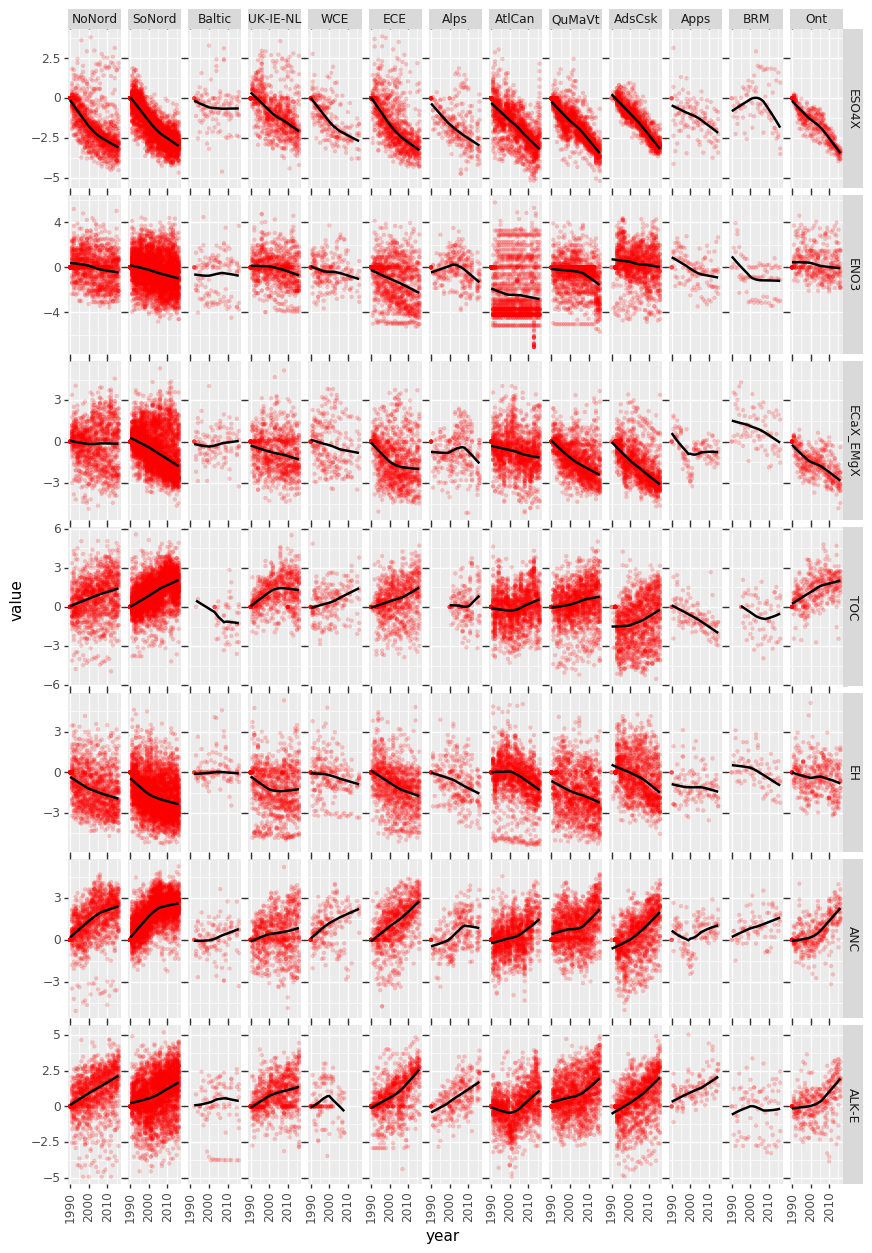

<ggplot: (142809146411)>

In [9]:
# Static plot
p = (ggplot(df, aes('year', 'value'))
     + geom_point(alpha=0.2, stroke=0.1, color='red')
     + stat_smooth(method='lowess', se=False)
     + facet_grid('variable~region', scales='free_y', shrink=True)
     + theme(axis_text_x=element_text(rotation=90)))
p

In [10]:
out_png = r'../../../Thematic_Trends_Report_2019/results/raw_wq_trends_all.png'
p.save(out_png, width=8, height=12, units='in', dpi=300)